In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from h_strategy import HConstruction
from h_strategy import HSelection

In [2]:
# Getting the date of the first day of each quarter
dates = pd.date_range("1995-01-01", "2024-07-01", freq = "QS")

# Setting parameters for getting training and testing intervals
interval = 4
overlap = 2

train_date = []
test_date = []

# Determining training and testing intervals
i = 0
while i < len(dates) - interval - overlap:
    trd = (dates[i].date(), dates[i + interval].date())
    tsd = (dates[i + interval].date(), dates[i + interval + overlap].date())
    
    train_date.append(trd)
    test_date.append(tsd)
    
    i += 2
    
# Printing out some of the training and testing intervals
for train, test in zip(train_date[:5], test_date[:5]):
    print("Training:", train[0], "~", train[1], "Testing:", test[0], "~", test[1])

Training: 1995-01-01 ~ 1996-01-01 Testing: 1996-01-01 ~ 1996-07-01
Training: 1995-07-01 ~ 1996-07-01 Testing: 1996-07-01 ~ 1997-01-01
Training: 1996-01-01 ~ 1997-01-01 Testing: 1997-01-01 ~ 1997-07-01
Training: 1996-07-01 ~ 1997-07-01 Testing: 1997-07-01 ~ 1998-01-01
Training: 1997-01-01 ~ 1998-01-01 Testing: 1998-01-01 ~ 1998-07-01


In [3]:
# Getting data path
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_1 = os.path.join(root_path, "SP500_Kagi_contrarian_20", "S&P 500_Components.csv")
path_2 = os.path.join(root_path, "SP500_Kagi_contrarian_20", "sp500_adj_close_prices.csv")

In [4]:
# Reading data
components = pd.read_csv(path_1, index_col = 0)
components.columns = components.columns.astype(str)
data_df = pd.read_csv(path_2, index_col = 0)
data_df.index = pd.to_datetime(data_df.index)
tickers_with_data = list(data_df.columns)

In [5]:
def cal_daily_returns(price_data, position):
    cum_return = position*(price_data - price_data.iloc[0])/price_data.iloc[0]
    daily_returns = (cum_return + 1).pct_change().dropna()
    return daily_returns

In [6]:
# Setting parameters
construction_type = "Kagi"
signals_type = "contrarian"
selection_method = "highest"
transaction_costs = 0.0010
num = 20

# Creating series for storing backtesting results
total_returns = pd.Series(1, index = [test_date[0][0]], dtype = float)
total_returns_with_costs = pd.Series(1, index = [test_date[0][0]], dtype = float)
total_returns.index = pd.to_datetime(total_returns.index)
total_returns_with_costs.index = pd.to_datetime(total_returns_with_costs.index)

# Starting backtesting
for train, test in zip(train_date, test_date):
    train_year = str(train[0].year) # Getting the year of the start of the training interval
    tickers = list(components[train_year].dropna()) # Getting S&P 500 components for the year
    valid_tickers = list(set(tickers_with_data) & set(tickers)) # Determining which Tickers have historical data
    
    train_data = data_df[valid_tickers][train[0] : train[1]] # Getting required data for pairs selection
    train_data = train_data.dropna(how = "all", axis = 0).dropna(how = "all", axis = 1)
    
    # Getting pairs for trading
    minimum_length = len(train_data)*0.8
    hs = HSelection(train_data, construction_type)
    hs.select(minimum_length = minimum_length)
    pairs = hs.get_pairs(num, selection_method, False)
    
    # Creating lists for storing cumulative returns in the test interval for each pair
    returns_series_list = []
    returns_series_with_costs_list = []
    
    print("Training:", train[0], "~", train[1])
    print("Testing:", test[0], "~", test[1])
    
    # Calculating the cumulative returns in the test interval for each pair
    for i in pairs:
        threshold = i[1] # Getting the threshold of the H-construction
        pair_tickers = list(i[2])
        pair_data = data_df[pair_tickers][test[0] : test[1]] # Getting required data for backtesting
        pair_data = pair_data.dropna(axis = 0).dropna(axis = 1)
        
        if len(pair_data.columns) < 2:
            print("data error")
            continue
        
        series = np.log(pair_data[pair_tickers[0]]) - np.log(pair_data[pair_tickers[1]]) # Constructing spread series
        
        # 如果 series 是空的，跳过这个 pair
        if series.empty:
            print(f"Skipping pair {pair_tickers[0]} and {pair_tickers[1]} due to empty series.")
            continue
            
        hc = HConstruction(series, threshold, construction_type) # Creating a class object
        signals = hc.get_signals(signals_type) # Getting the signals in the test interval
        trade_actions = signals[signals != 0] # Getting the actual trade actions (+1 for Open a long trade, -1 for Open a short trade)
        trade_dates_interval = [(trade_actions.index[i].date(), trade_actions.index[i + 1].date()) for i in range(len(trade_actions) - 1)] # Getting the intervals between two adjacent trade actions
        if len(trade_actions) > 0 and trade_actions.index[-1].date() < test[1]:
            trade_dates_interval.append([trade_actions.index[-1].date(), test[1]])
            
        # Creating series for storing cumulative returns
        returns_series = pd.Series(1, index = [test[0]], dtype = float)
        returns_series.index = pd.to_datetime(returns_series.index)
        returns_series_with_costs = pd.Series(1, index = [test[0]], dtype = float)
        returns_series_with_costs.index = pd.to_datetime(returns_series_with_costs.index)
        
        # Calculating the cumulative returns for each interval between two adjacent trade actions, then connecting them together
        for i, j in zip(trade_dates_interval, trade_actions.values):
            interval_data = pair_data.loc[i[0]:i[1]].dropna(how = "all", axis = 0).dropna(how = "all", axis = 1)
            if len(interval_data) <= 1:
                continue
                
            daily_returns = interval_data.copy()
            daily_returns[pair_tickers[0]] = cal_daily_returns(daily_returns[pair_tickers[0]], j) # if j == 1 (-1), long (short) the first stock and short (long) the second stock
            daily_returns[pair_tickers[1]] = cal_daily_returns(daily_returns[pair_tickers[1]], -j)
            daily_returns = daily_returns.dropna(how = "all", axis = 0).dropna(how = "all", axis = 1)
            
            daily_returns_with_costs = daily_returns.copy()
            daily_returns_with_costs.iloc[0] = daily_returns_with_costs.iloc[0] - transaction_costs
            daily_returns_with_costs.iloc[-1] = daily_returns_with_costs.iloc[-1] - transaction_costs
            
            cum_returns = (daily_returns + 1).cumprod().mean(axis = 1) # Assuming we have equal weights at the first day of the interval between two adjacent trade actions
            cum_returns_with_costs = (daily_returns_with_costs + 1).cumprod().mean(axis = 1)
            returns_series = pd.concat([returns_series, cum_returns*returns_series[-1]])
            returns_series_with_costs = pd.concat([returns_series_with_costs, cum_returns_with_costs * returns_series_with_costs[-1]])
        
        returns_series_list.append(returns_series)
        returns_series_with_costs_list.append(returns_series_with_costs)
        
    pairs_returns = pd.DataFrame(returns_series_list).T.ffill().mean(axis = 1) # Assuming we have equal weights at the first day of the test interval
    total_returns = pd.concat([total_returns, pairs_returns*total_returns[-1]])
    pairs_returns_with_costs = pd.DataFrame(returns_series_with_costs_list).T.ffill().mean(axis = 1)
    total_returns_with_costs = pd.concat([total_returns_with_costs, pairs_returns_with_costs * total_returns_with_costs[-1]])

100%|██████████████████████████████████████████████████████████████████████████████| 9316/9316 [02:06<00:00, 73.52it/s]


Training: 1995-01-01 ~ 1996-01-01
Testing: 1996-01-01 ~ 1996-07-01


100%|█████████████████████████████████████████████████████████████████████████████| 9316/9316 [01:32<00:00, 100.66it/s]


Training: 1995-07-01 ~ 1996-07-01
Testing: 1996-07-01 ~ 1997-01-01


100%|███████████████████████████████████████████████████████████████████████████| 10878/10878 [01:28<00:00, 122.42it/s]


Training: 1996-01-01 ~ 1997-01-01
Testing: 1997-01-01 ~ 1997-07-01


100%|███████████████████████████████████████████████████████████████████████████| 10878/10878 [01:45<00:00, 102.91it/s]


Training: 1996-07-01 ~ 1997-07-01
Testing: 1997-07-01 ~ 1998-01-01


100%|███████████████████████████████████████████████████████████████████████████| 11325/11325 [01:36<00:00, 116.80it/s]


Training: 1997-01-01 ~ 1998-01-01
Testing: 1998-01-01 ~ 1998-07-01


100%|████████████████████████████████████████████████████████████████████████████| 11325/11325 [01:59<00:00, 94.64it/s]


Training: 1997-07-01 ~ 1998-07-01
Testing: 1998-07-01 ~ 1999-01-01


100%|████████████████████████████████████████████████████████████████████████████| 13695/13695 [02:32<00:00, 89.56it/s]


Training: 1998-01-01 ~ 1999-01-01
Testing: 1999-01-01 ~ 1999-07-01


100%|████████████████████████████████████████████████████████████████████████████| 13695/13695 [02:19<00:00, 98.27it/s]


Training: 1998-07-01 ~ 1999-07-01
Testing: 1999-07-01 ~ 2000-01-01


100%|███████████████████████████████████████████████████████████████████████████| 15753/15753 [02:26<00:00, 107.69it/s]


Training: 1999-01-01 ~ 2000-01-01
Testing: 2000-01-01 ~ 2000-07-01


100%|████████████████████████████████████████████████████████████████████████████| 15753/15753 [03:10<00:00, 82.50it/s]


Training: 1999-07-01 ~ 2000-07-01
Testing: 2000-07-01 ~ 2001-01-01


100%|███████████████████████████████████████████████████████████████████████████| 17766/17766 [02:49<00:00, 104.83it/s]


Training: 2000-01-01 ~ 2001-01-01
Testing: 2001-01-01 ~ 2001-07-01


100%|████████████████████████████████████████████████████████████████████████████| 17766/17766 [03:07<00:00, 94.97it/s]


Training: 2000-07-01 ~ 2001-07-01
Testing: 2001-07-01 ~ 2002-01-01


100%|███████████████████████████████████████████████████████████████████████████| 19306/19306 [02:29<00:00, 128.98it/s]


Training: 2001-01-01 ~ 2002-01-01
Testing: 2002-01-01 ~ 2002-07-01


100%|███████████████████████████████████████████████████████████████████████████| 19306/19306 [02:47<00:00, 115.20it/s]


Training: 2001-07-01 ~ 2002-07-01
Testing: 2002-07-01 ~ 2003-01-01


100%|████████████████████████████████████████████████████████████████████████████| 19900/19900 [03:41<00:00, 89.82it/s]


Training: 2002-01-01 ~ 2003-01-01
Testing: 2003-01-01 ~ 2003-07-01


100%|███████████████████████████████████████████████████████████████████████████| 19900/19900 [02:29<00:00, 133.42it/s]


Training: 2002-07-01 ~ 2003-07-01
Testing: 2003-07-01 ~ 2004-01-01


100%|███████████████████████████████████████████████████████████████████████████| 21945/21945 [03:07<00:00, 116.99it/s]


Training: 2003-01-01 ~ 2004-01-01
Testing: 2004-01-01 ~ 2004-07-01


100%|███████████████████████████████████████████████████████████████████████████| 21945/21945 [03:09<00:00, 115.59it/s]


Training: 2003-07-01 ~ 2004-07-01
Testing: 2004-07-01 ~ 2005-01-01


100%|███████████████████████████████████████████████████████████████████████████| 22366/22366 [03:27<00:00, 108.01it/s]


Training: 2004-01-01 ~ 2005-01-01
Testing: 2005-01-01 ~ 2005-07-01


100%|███████████████████████████████████████████████████████████████████████████| 22366/22366 [03:42<00:00, 100.51it/s]


Training: 2004-07-01 ~ 2005-07-01
Testing: 2005-07-01 ~ 2006-01-01


100%|███████████████████████████████████████████████████████████████████████████| 23653/23653 [03:35<00:00, 109.90it/s]


Training: 2005-01-01 ~ 2006-01-01
Testing: 2006-01-01 ~ 2006-07-01


100%|███████████████████████████████████████████████████████████████████████████| 23653/23653 [03:47<00:00, 104.09it/s]


Training: 2005-07-01 ~ 2006-07-01
Testing: 2006-07-01 ~ 2007-01-01


100%|███████████████████████████████████████████████████████████████████████████| 25200/25200 [03:48<00:00, 110.25it/s]


Training: 2006-01-01 ~ 2007-01-01
Testing: 2007-01-01 ~ 2007-07-01


100%|███████████████████████████████████████████████████████████████████████████| 25200/25200 [03:23<00:00, 123.84it/s]


Training: 2006-07-01 ~ 2007-07-01
Testing: 2007-07-01 ~ 2008-01-01


100%|████████████████████████████████████████████████████████████████████████████| 27495/27495 [05:41<00:00, 80.62it/s]


Training: 2007-01-01 ~ 2008-01-01
Testing: 2008-01-01 ~ 2008-07-01


100%|████████████████████████████████████████████████████████████████████████████| 27495/27495 [05:10<00:00, 88.49it/s]


Training: 2007-07-01 ~ 2008-07-01
Testing: 2008-07-01 ~ 2009-01-01


100%|████████████████████████████████████████████████████████████████████████████| 30876/30876 [06:15<00:00, 82.12it/s]


Training: 2008-01-01 ~ 2009-01-01
Testing: 2009-01-01 ~ 2009-07-01


100%|████████████████████████████████████████████████████████████████████████████| 30876/30876 [05:50<00:00, 88.01it/s]


Training: 2008-07-01 ~ 2009-07-01
Testing: 2009-07-01 ~ 2010-01-01


100%|███████████████████████████████████████████████████████████████████████████| 34980/34980 [04:19<00:00, 134.57it/s]


Training: 2009-01-01 ~ 2010-01-01
Testing: 2010-01-01 ~ 2010-07-01


100%|███████████████████████████████████████████████████████████████████████████| 34980/34980 [04:38<00:00, 125.65it/s]


Training: 2009-07-01 ~ 2010-07-01
Testing: 2010-07-01 ~ 2011-01-01


100%|███████████████████████████████████████████████████████████████████████████| 38503/38503 [05:57<00:00, 107.59it/s]


Training: 2010-01-01 ~ 2011-01-01
Testing: 2011-01-01 ~ 2011-07-01


100%|███████████████████████████████████████████████████████████████████████████| 38503/38503 [05:51<00:00, 109.49it/s]


Training: 2010-07-01 ~ 2011-07-01
Testing: 2011-07-01 ~ 2012-01-01


100%|████████████████████████████████████████████████████████████████████████████| 40755/40755 [08:16<00:00, 82.12it/s]


Training: 2011-01-01 ~ 2012-01-01
Testing: 2012-01-01 ~ 2012-07-01


100%|███████████████████████████████████████████████████████████████████████████| 40755/40755 [06:12<00:00, 109.41it/s]


Training: 2011-07-01 ~ 2012-07-01
Testing: 2012-07-01 ~ 2013-01-01


100%|███████████████████████████████████████████████████████████████████████████| 43660/43660 [06:44<00:00, 107.89it/s]


Training: 2012-01-01 ~ 2013-01-01
Testing: 2013-01-01 ~ 2013-07-01


100%|████████████████████████████████████████████████████████████████████████████| 43660/43660 [07:35<00:00, 95.90it/s]


Training: 2012-07-01 ~ 2013-07-01
Testing: 2013-07-01 ~ 2014-01-01


100%|████████████████████████████████████████████████████████████████████████████| 46665/46665 [08:55<00:00, 87.20it/s]


Training: 2013-01-01 ~ 2014-01-01
Testing: 2014-01-01 ~ 2014-07-01


100%|████████████████████████████████████████████████████████████████████████████| 46665/46665 [07:48<00:00, 99.53it/s]


Training: 2013-07-01 ~ 2014-07-01
Testing: 2014-07-01 ~ 2015-01-01


100%|███████████████████████████████████████████████████████████████████████████| 48516/48516 [07:45<00:00, 104.15it/s]


Training: 2014-01-01 ~ 2015-01-01
Testing: 2015-01-01 ~ 2015-07-01


100%|████████████████████████████████████████████████████████████████████████████| 48516/48516 [09:47<00:00, 82.58it/s]


Training: 2014-07-01 ~ 2015-07-01
Testing: 2015-07-01 ~ 2016-01-01


100%|████████████████████████████████████████████████████████████████████████████| 50721/50721 [09:44<00:00, 86.82it/s]


Training: 2015-01-01 ~ 2016-01-01
Testing: 2016-01-01 ~ 2016-07-01


100%|████████████████████████████████████████████████████████████████████████████| 50721/50721 [09:13<00:00, 91.70it/s]


Training: 2015-07-01 ~ 2016-07-01
Testing: 2016-07-01 ~ 2017-01-01


100%|███████████████████████████████████████████████████████████████████████████| 55945/55945 [07:35<00:00, 122.87it/s]


Training: 2016-01-01 ~ 2017-01-01
Testing: 2017-01-01 ~ 2017-07-01


100%|████████████████████████████████████████████████████████████████████████████| 55945/55945 [10:10<00:00, 91.59it/s]


Training: 2016-07-01 ~ 2017-07-01
Testing: 2017-07-01 ~ 2018-01-01


100%|████████████████████████████████████████████████████████████████████████████| 63190/63190 [13:53<00:00, 75.83it/s]


Training: 2017-01-01 ~ 2018-01-01
Testing: 2018-01-01 ~ 2018-07-01


100%|████████████████████████████████████████████████████████████████████████████| 63190/63190 [17:21<00:00, 60.68it/s]


Training: 2017-07-01 ~ 2018-07-01
Testing: 2018-07-01 ~ 2019-01-01


100%|████████████████████████████████████████████████████████████████████████████| 70876/70876 [15:56<00:00, 74.07it/s]


Training: 2018-01-01 ~ 2019-01-01
Testing: 2019-01-01 ~ 2019-07-01


100%|████████████████████████████████████████████████████████████████████████████| 70876/70876 [15:02<00:00, 78.50it/s]


Training: 2018-07-01 ~ 2019-07-01
Testing: 2019-07-01 ~ 2020-01-01


100%|███████████████████████████████████████████████████████████████████████████| 75855/75855 [12:10<00:00, 103.79it/s]


Training: 2019-01-01 ~ 2020-01-01
Testing: 2020-01-01 ~ 2020-07-01


100%|████████████████████████████████████████████████████████████████████████████| 75855/75855 [22:00<00:00, 57.44it/s]


Training: 2019-07-01 ~ 2020-07-01
Testing: 2020-07-01 ~ 2021-01-01


100%|████████████████████████████████████████████████████████████████████████████| 83845/83845 [14:26<00:00, 96.73it/s]


Training: 2020-01-01 ~ 2021-01-01
Testing: 2021-01-01 ~ 2021-07-01


100%|███████████████████████████████████████████████████████████████████████████| 83845/83845 [12:37<00:00, 110.70it/s]


Training: 2020-07-01 ~ 2021-07-01
Testing: 2021-07-01 ~ 2022-01-01


100%|███████████████████████████████████████████████████████████████████████████| 89676/89676 [11:12<00:00, 133.40it/s]


Training: 2021-01-01 ~ 2022-01-01
Testing: 2022-01-01 ~ 2022-07-01


100%|████████████████████████████████████████████████████████████████████████████| 89676/89676 [36:38<00:00, 40.79it/s]


Training: 2021-07-01 ~ 2022-07-01
Testing: 2022-07-01 ~ 2023-01-01


100%|███████████████████████████████████████████████████████████████████████████| 89676/89676 [10:59<00:00, 136.05it/s]


Training: 2022-01-01 ~ 2023-01-01
Testing: 2023-01-01 ~ 2023-07-01


100%|████████████████████████████████████████████████████████████████████████████| 89676/89676 [18:35<00:00, 80.36it/s]


Training: 2022-07-01 ~ 2023-07-01
Testing: 2023-07-01 ~ 2024-01-01


100%|████████████████████████████████████████████████████████████████████████████| 89676/89676 [32:25<00:00, 46.10it/s]


Training: 2023-01-01 ~ 2024-01-01
Testing: 2024-01-01 ~ 2024-07-01


In [7]:
# Getting benckmark
start = total_returns.index[0].date().isoformat()
end = total_returns.index[-1].date().isoformat()
SP500 = yf.download("^GSPC", start=start, end=end)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


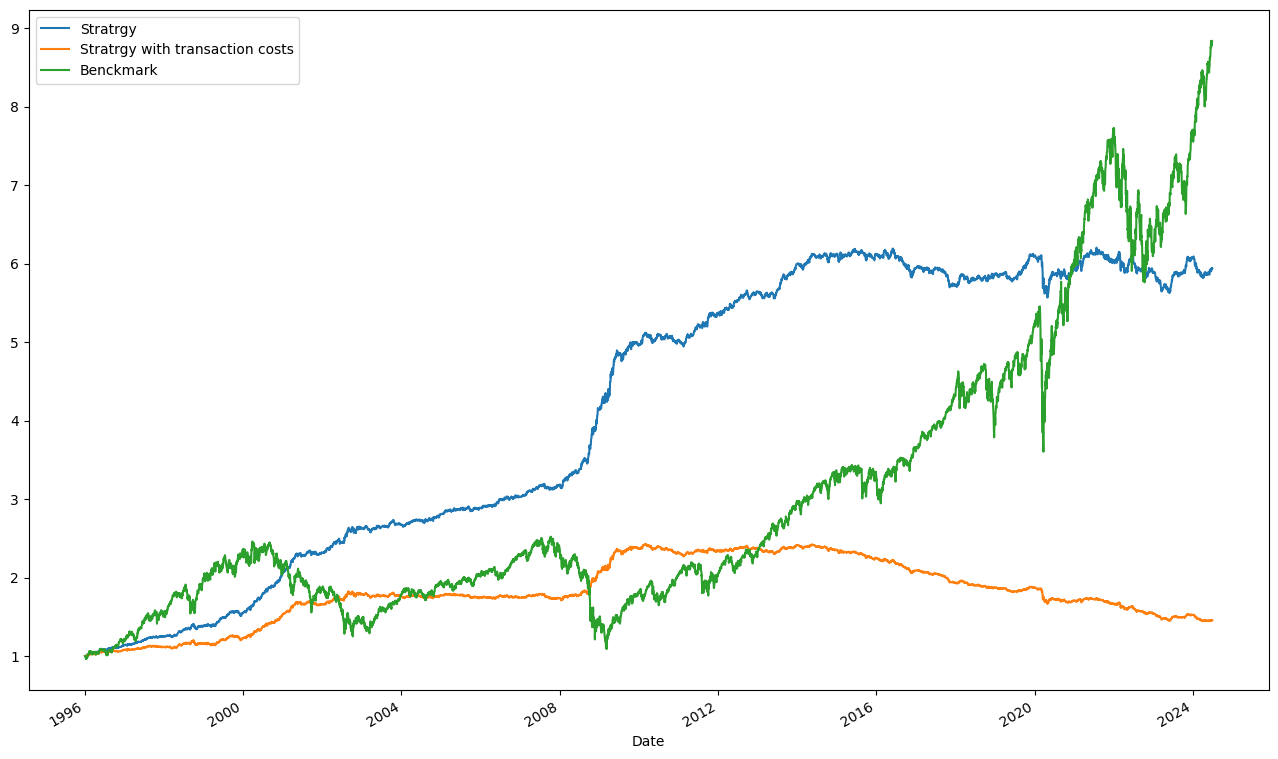

In [8]:
# Plotting results
total_returns.plot(figsize=(16, 10), label = "Stratrgy")
total_returns_with_costs.plot(label = "Stratrgy with transaction costs")
(SP500.pct_change() + 1).cumprod().plot(label = "Benckmark")
plt.legend()
plt.show()

In [9]:
total_returns

1996-01-01    1.000000
1996-01-01    1.000000
1996-01-04    1.001686
1996-01-05    1.002580
1996-01-08    1.001355
                ...   
2024-06-24    5.944552
2024-06-25    5.931796
2024-06-26    5.947036
2024-06-27    5.941239
2024-06-28    5.937467
Length: 7106, dtype: float64

In [10]:
# 假设 total_returns 是您的 pandas Series 对象
output_file = "total_returns.xlsx"

# 将 total_returns 保存到 Excel 文件
total_returns.to_excel(output_file, sheet_name="Total Returns")

print(f"数据已保存到 '{output_file}'")

数据已保存到 'total_returns.xlsx'


In [11]:
total_returns_with_costs

1996-01-01    1.000000
1996-01-01    1.000000
1996-01-04    1.001436
1996-01-05    1.002079
1996-01-08    1.000604
                ...   
2024-06-24    1.460865
2024-06-25    1.457408
2024-06-26    1.461014
2024-06-27    1.459192
2024-06-28    1.456579
Length: 7106, dtype: float64

In [12]:
# 假设 total_returns 是您的 pandas Series 对象
output_file = "total_returns_with_costs.xlsx"

# 将 total_returns 保存到 Excel 文件
total_returns_with_costs.to_excel(output_file, sheet_name="total_returns_with_costs")

print(f"数据已保存到 '{output_file}'")

数据已保存到 'total_returns_with_costs.xlsx'
